IMPORTANT: submissions in test set should be different from train set, i.e., `train_test_different_submissions = True`

In [50]:
CONFIG_PATH = "configs/subreddit_minority_no_peer_test_diff.yml"
from utils import get_config
config = get_config(CONFIG_PATH, "_curation", print_config = False)
peer_vote_option = "real" # "real", "real_user_same_vote", "similar_user_same_vote", "real_user_opposite_vote", "similar_user_opposite_vote"
from superdebug import debug
debug(peer_vote_option=peer_vote_option)
use_voted_users_feature = config["use_voted_users_feature"]
use_voted_users_feature = False
if use_voted_users_feature:
    print("Use peer votes as model input feature")
else:
    print("Finetune the model using peer votes")

GPU ready...
Smart using cuda:3
------------------ 2022-09-14 16:33:22 ------------------
DEBUG: 1 vars: ['peer_vote_option'], at <ipython-input-50-81dd585ce79b>:6 <module>
0 / 9.  peer_vote_option str len 4: real
------------------ 2022-09-14 16:33:22 ------------------
Finetune the model using peer votes


In [51]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
import torch
from process_data import get_model_input
from model import get_best_model, TransformerVoter
from utils import get_user_reps, get_bool_vec, record_existing_votes
from train import evaluate_model, train_model
import sklearn.metrics
import copy

In [52]:
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
extra_input = (categorical_features, string_features, target)

------------------ 2022-09-14 16:33:23 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:363 get_model_input
Loading prepared data...
------------------ 2022-09-14 16:33:23 ------------------


In [53]:
model, _ = get_best_model(config, categorical_features, string_features, original_feature_map)

------------------ 2022-09-14 16:33:28 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:251 get_tokenizer
0 / 10.  original_token_num num val: 30522
------------------ 2022-09-14 16:33:28 ------------------
------------------ 2022-09-14 16:33:28 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:263 get_tokenizer
0 / 11.  latest_token_num num val: 219887
------------------ 2022-09-14 16:33:28 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


------------------ 2022-09-14 16:33:30 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:115 load_model
Loading best model...
------------------ 2022-09-14 16:33:30 ------------------


In [54]:
print(model.device)
test_data.iloc[:2]
# !nvidia-smi

cuda:3


,SUBMISSION_ID,SUBREDDIT,CREATED_TIME,USERNAME,VOTE,TITLE,AUTHOR,#_COMMENTS,NSFW,SCORE,UPVOTED_%,LINK,SUBMISSION_TEXT,SUBMISSION_URL
0,t3_dpesbw,r/teenagers,Wed Oct 30 2019,54180,1.0,"Well boys, i finally did it.",118334,292,false,7158,0.96,https://www.reddit.com/r/teenagers/comments/dp...,"Well boys, i finally did it. [SEP] [deleted]",https://i.redd.it/q5kh7gz3irv31.png
1,t3_e0xr9r,r/teenagers,Sun Nov 24 2019,23277,1.0,Why tf are there 17 hour posts and 1 minute po...,58381,74,false,5015,0.99,https://www.reddit.com/r/teenagers/comments/e0...,Why tf are there 17 hour posts and 1 minute po...,https://www.reddit.com/r/teenagers/comments/e0...


Define functions to simulate new peer votes

In [55]:
def count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data):
    peer_votes_num_acc_df.at[peer_vote_num, "Total"] += 1
    pred_target_vote = int(pred_target_vote_score >= 0.5)
    peer_votes_num_acc_df.at[peer_vote_num, "Acc"] += int(pred_target_vote == target_vote)
    peer_votes_num_acc_df.at[peer_vote_num, "Confidence"] += abs(1- target_vote - pred_target_vote_score)
        
    if peer_vote_num > 0:
        majority_vote = -1
        if sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num > 0.5:
            majority_vote = 1
        elif sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num < 0.5:
            majority_vote = 0
        if pred_target_vote == majority_vote:
            peer_votes_num_acc_df.at[peer_vote_num, "Same as majority"] += 1

def pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data):
    all_peer_users = peer_votes_data["USERNAME"].to_numpy()
    all_peer_votes = peer_votes_data["VOTE"].to_numpy()
    upvoted_users, downvoted_users = [], []
    for new_user_i in range(-1, len(all_peer_users)):
        peer_vote_num = new_user_i + 1
        if new_user_i >= 0:
            new_user = all_peer_users[new_user_i]
            new_vote = all_peer_votes[new_user_i]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
        target_vote_data.at[0, "UPVOTED_USERS"] = upvoted_users
        target_vote_data.at[0, "DOWNVOTED_USERS"] = downvoted_users
        pred_target_vote_score = evaluate_model(config, model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
        count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

def pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=1):
    tmp_model = copy.deepcopy(model)
    # 0 peer votes
    pred_target_vote_score = evaluate_model(config, tmp_model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
    count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, 0, peer_votes_data)

    if len(peer_votes_data) > 0:
        for new_user_i, tmp_model in enumerate(train_model(config, tmp_model, data=peer_votes_data, weights = None, batch_size=1, epochs=1, verbose=2, validation_split=False, step_generator=True, n_step_per_sample=n_step_per_sample, extra_input = extra_input)):
            if tmp_model is None:
                break
            peer_vote_num = new_user_i + 1
            pred_target_vote_score = evaluate_model(config, tmp_model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
            count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

In [56]:
n_step_per_sample = 1
if not use_voted_users_feature:
    model.optim = torch.optim.Adam(model.parameters(), lr = 1.2 * config["learning_rate"]) # 2 还不错，5不行
    n_step_per_sample = 1

In [57]:
if peer_vote_option == "similar_user_opposite_vote" or peer_vote_option == "similar_user_same_vote":
    existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes, existing_user_subreddits = record_existing_votes(train_data)

    all_users = list(range(max(max(train_data["USERNAME"]), max(test_data["USERNAME"])) + 1))
    all_username_tokens = [f"USERNAME_{user_i}" for user_i in all_users]
    all_username_token_ids = torch.tensor(model.tokenizer.convert_tokens_to_ids(all_username_tokens))
    all_username_token_ids = all_username_token_ids.to(model.device); model = model.to(model.device)
    with torch.no_grad():
        user_embedding = model.lm_encoder.embeddings.word_embeddings(all_username_token_ids)
    # debug(all_username_tokens=all_username_tokens, all_username_token_ids=all_username_token_ids, user_embedding=user_embedding)
    all_users_reps, all_user_i_user_map = get_user_reps(all_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = {key: None for key in set(train_data["SUBMISSION_ID"])}, user_grouping_method = "votes", do_PCA = False)

    user_similarity = sklearn.metrics.pairwise.cosine_similarity(all_users_reps)


Simulate new votes coming and calculate the accuracy

In [58]:
from tqdm import tqdm

test_submissions = list(set(test_data["SUBMISSION_ID"]))
max_voted_users = 1000
xlim = 50
peer_votes_num_acc_df = pd.DataFrame(np.zeros((max_voted_users + 1,4)), columns=['Acc', 'Confidence', 'Total', "Same as majority"])
model = model.to(model.device)
assert len(peer_votes_num_acc_df) == 1001

In [59]:
# test_data["UPVOTED_USERS"] = test_data["UPVOTED_USERS"].astype('object')
# test_data["DOWNVOTED_USERS"] = test_data["DOWNVOTED_USERS"].astype('object')

for submission_id in tqdm(test_submissions[1000:2000]):
    submission_votes_data = test_data[test_data["SUBMISSION_ID"] == submission_id]
    submission_votes_data = submission_votes_data.sample(frac=1).reset_index(drop=True) # shuffle
    target_vote_data = submission_votes_data.iloc[-1:].reset_index(drop=True)
    target_vote = int(target_vote_data["VOTE"])
    peer_votes_data = submission_votes_data.iloc[:-1]
    # peer_votes_data = peer_votes_data[:xlim]
    if peer_vote_option == "real":
        pass
    elif peer_vote_option == "real_user_opposite_vote":
        peer_votes_data.loc[:,"VOTE"] = [1 - target_vote] * len(peer_votes_data)
    elif peer_vote_option == "real_user_same_vote":
        peer_votes_data.loc[:,"VOTE"] = [target_vote] * len(peer_votes_data)
    elif peer_vote_option == "similar_user_opposite_vote":
        target_user = int(target_vote_data["USERNAME"])
        similar_users = user_similarity[target_user].argsort()[::-1][:xlim]
        peer_votes_data = pd.concat([target_vote_data] * xlim, axis = 0)
        peer_votes_data["USERNAME"] = similar_users
        peer_votes_data["VOTE"] = [1 - target_vote] * xlim
    elif peer_vote_option == "similar_user_same_vote":
        target_user = int(target_vote_data["USERNAME"])
        similar_users = user_similarity[target_user].argsort()[::-1][:xlim]
        peer_votes_data = pd.concat([target_vote_data] * xlim, axis = 0)
        peer_votes_data["USERNAME"] = similar_users
        peer_votes_data["VOTE"] = [target_vote] * xlim
    if use_voted_users_feature:
        pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data)
        # pred_acc_peer_feature_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)
    else:
        pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)
        

100%|██████████| 1000/1000 [17:33<00:00,  1.05s/it]


In [60]:
peer_votes_num_acc_df = peer_votes_num_acc_df[peer_votes_num_acc_df["Total"] > 0]
peer_votes_num_acc_df["Accuracy"] = peer_votes_num_acc_df["Acc"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Confidence"] = peer_votes_num_acc_df["Confidence"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Same as majority rate"] = peer_votes_num_acc_df["Same as majority"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Total scaled"] = peer_votes_num_acc_df["Total"]/max(peer_votes_num_acc_df["Total"])
peer_votes_num_acc_df

,Acc,Confidence,Total,Same as majority,Accuracy,Same as majority rate,Total scaled
0,740.0,0.716675,1000.0,0.0,0.740000,0.000000,1.000
1,236.0,0.683291,336.0,210.0,0.702381,0.625000,0.336
2,156.0,0.705694,215.0,104.0,0.725581,0.483721,0.215
3,124.0,0.708696,168.0,111.0,0.738095,0.660714,0.168
4,88.0,0.696234,124.0,64.0,0.709677,0.516129,0.124
...,...,...,...,...,...,...,...
270,1.0,0.993578,1.0,1.0,1.000000,1.000000,0.001
271,1.0,0.993760,1.0,1.0,1.000000,1.000000,0.001
272,1.0,0.993928,1.0,1.0,1.000000,1.000000,0.001
273,1.0,0.994085,1.0,1.0,1.000000,1.000000,0.001


------------------ 2022-09-14 16:51:18 ------------------
DEBUG: at <ipython-input-61-754ebc79e6f7>:6 <module>
Confidence and accuracy
------------------ 2022-09-14 16:51:18 ------------------


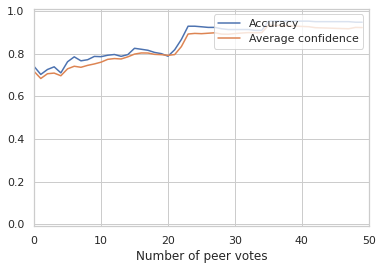

In [61]:
def convert_df_to_dict(df: pd.DataFrame):
    return {x:list(df[x]) for x in df}
import seaborn as sns
from matplotlib import pyplot as plt
peer_votes_num_acc_df_part = peer_votes_num_acc_df.iloc[:xlim]
debug("Confidence and accuracy")
sns.set_theme(style="whitegrid")
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Accuracy', label = "Accuracy")
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Confidence', label = "Average confidence")
# sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
ax.legend(loc='upper right')
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([0, xlim])
plt.xlabel("Number of peer votes")
plt.ylabel("")
plt.show()

Text(0.5, 0, 'Number of peer votes')

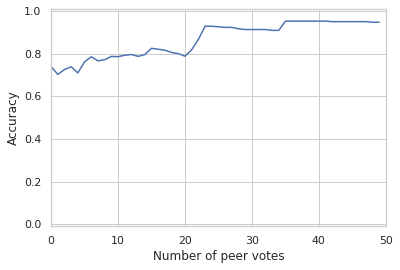

In [62]:
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Accuracy')
# sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([0, xlim])
plt.xlabel("Number of peer votes")

------------------ 2022-09-14 16:51:19 ------------------
DEBUG: at <ipython-input-63-f4e2ca066c58>:1 <module>
Same as majority rate
------------------ 2022-09-14 16:51:19 ------------------


Text(0.5, 0, 'Number of peer votes')

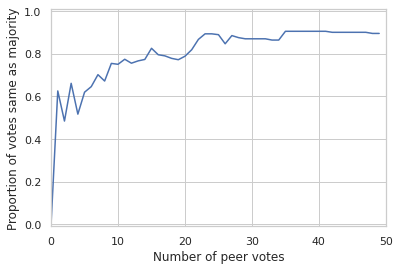

In [63]:
debug("Same as majority rate")
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Same as majority rate')
# sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([0, xlim])
ax.set_ylabel("Proportion of votes same as majority")
plt.xlabel("Number of peer votes")

In [64]:
peer_votes_num_acc_df_part["Confidence"]

0     0.716675
1     0.683291
2     0.705694
3     0.708696
4     0.696234
5     0.728646
6     0.740799
7     0.735909
8     0.744944
9     0.751597
10    0.759903
11    0.773196
12    0.776842
13    0.774880
14    0.784871
15    0.797776
16    0.803139
17    0.802806
18    0.796558
19    0.795108
20    0.791958
21    0.795546
22    0.833102
23    0.891968
24    0.894867
25    0.893569
26    0.895710
27    0.897752
28    0.891570
29    0.890972
30    0.894092
31    0.896587
32    0.898658
33    0.897931
34    0.898446
35    0.933009
36    0.932079
37    0.931027
38    0.929901
39    0.928839
40    0.927614
41    0.926347
42    0.921704
43    0.920670
44    0.919716
45    0.918648
46    0.917637
47    0.916810
48    0.922964
49    0.922212
Name: Confidence, dtype: float64